Reference: https://www.tensorflow.org/tutorials/audio/music_generation

In [ ]:
%%capture
!sudo apt install -y fluidsynth
!pip install pretty_midi
!pip install --upgrade pyfluidsynth

In [ ]:
from google.colab import drive
drive.mount('/drive')
!unzip /drive/Shareddrives/CIS\ 522\ Final\ Project/maestro-v3.0.0-midi.zip -d .

Mounted at /drive
Archive:  /drive/Shareddrives/CIS 522 Final Project/maestro-v3.0.0-midi.zip
  inflating: ./maestro-v3.0.0/2004/MIDI-Unprocessed_XP_08_R1_2004_01-02_ORIG_MID--AUDIO_08_R1_2004_01_Track01_wav.midi  
  inflating: ./maestro-v3.0.0/2004/MIDI-Unprocessed_XP_09_R1_2004_05_ORIG_MID--AUDIO_09_R1_2004_06_Track06_wav.midi  
  inflating: ./maestro-v3.0.0/2004/MIDI-Unprocessed_XP_14_R1_2004_01-03_ORIG_MID--AUDIO_14_R1_2004_01_Track01_wav.midi  
  inflating: ./maestro-v3.0.0/2004/MIDI-Unprocessed_XP_01_R1_2004_01-02_ORIG_MID--AUDIO_01_R1_2004_03_Track03_wav.midi  
  inflating: ./maestro-v3.0.0/2004/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_09_Track09_wav.midi  
  inflating: ./maestro-v3.0.0/2004/MIDI-Unprocessed_XP_18_R1_2004_01-02_ORIG_MID--AUDIO_18_R1_2004_03_Track03_wav.midi  
  inflating: ./maestro-v3.0.0/2004/MIDI-Unprocessed_XP_19_R1_2004_01-02_ORIG_MID--AUDIO_19_R1_2004_01_Track01_wav.midi  
  inflating: ./maestro-v3.0.0/2004/MIDI-Unprocessed_XP_04_R1_

In [ ]:
import pretty_midi

pm = pretty_midi.PrettyMIDI('/content/maestro-v3.0.0/2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.midi')

In [ ]:
from IPython import display

waveform = pm.fluidsynth(fs=16000)
display.Audio(waveform[:30*16000], rate=16000)

In [ ]:
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def midi_to_notes(midi_file):
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

def plot_piano_roll(notes, count=None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [ ]:
notes = midi_to_notes('maestro-v3.0.0/2008/MIDI-Unprocessed_07_R2_2008_01-05_ORIG_MID--AUDIO_07_R2_2008_wav--1.midi')
notes

,pitch,start,end,step,duration
0,70,1.096354,2.878906,0.000000,1.782552
1,42,1.108073,2.712240,0.011719,1.604167
2,49,1.115885,2.580729,0.007812,1.464844
3,58,1.578125,1.791667,0.462240,0.213542
4,61,1.795573,1.944010,0.217448,0.148438
...,...,...,...,...,...
2546,54,368.733073,374.960938,0.016927,6.227865
2547,58,368.734375,375.006510,0.001302,6.272135
2548,37,368.769531,375.152344,0.035156,6.382812
2549,30,368.779948,375.145833,0.010417,6.365885


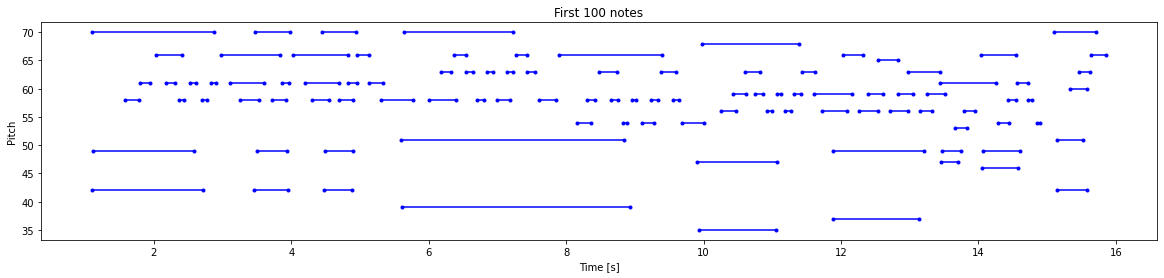

In [ ]:
plot_piano_roll(notes, 100)

In [ ]:
def get_note_name(pitch):
  pitch_classes = {0 : 'C', 1 : 'C#/Db', 2 : 'D', 3 : 'D#/Eb', 4 : 'E', 5 : 'F', \
                  6 : 'F#/Gb', 7 : 'G', 8 : 'G#/Ab', 9 : 'A', 10 : 'A#/Bb', 11 : 'B'}
  return pitch_classes[pitch % 12]

def get_pitch_class(pitch):
  return pitch % 12

print(get_note_name(37))
print(get_note_name(71))

C#/Db
B


# To-Do:
- Look at beat placement and downbeat
- Group notes by beat they fall into
- Form tokens, try different numbers k of notes to include in each token
- Find embeddings for each token

In [ ]:
def calculate_overlap(a_start_time, a_end_time, b_start_time, b_end_time):
  return max(min(a_end_time, b_end_time) - max(a_start_time, b_start_time), 0)

In [ ]:
from collections import Counter

held_notes = {}
pitch_class_dists = []
i = 0
for i in range(len(notes)):
  note = notes.iloc[i]
  # initialize a Counter for pitch classes (C, E, B, Bb, etc.)
  pitch_class_dist = Counter()
  # for all notes held over from before, check if ended or count overlap with current note
  held_notes_to_delete = []
  for held_note, held_end_time in held_notes.items():
    if held_end_time <= note.start:
      held_notes_to_delete.append(held_note)
    else:
      pitch_class_dist[get_pitch_class(held_note)] += calculate_overlap(note.start, note.end, note.start, held_end_time)
  # update held note dictionary
  for x in held_notes_to_delete:
    del held_notes[x]
  held_notes[note.pitch] = note.end
  # consider all forthcoming overlapping notes
  j = i + 1
  while j < len(notes) and notes.iloc[j].start < note.end:
    pitch_class_dist[get_pitch_class(notes.iloc[j].pitch)] += calculate_overlap(note.start, note.end, notes.iloc[j].start, notes.iloc[j].end)
    j += 1
  # store the pitch class distribution
  pitch_class_dists.append(pitch_class_dist)


In [ ]:
pitch_class_dists[0]

Counter({1.0: 1.8802083333333335,
         6.0: 1.9908854166666665,
         10.0: 0.3541666666666665})

In [ ]:
from heapq import nlargest

def return_top_n_classes(dist, N):
  return nlargest(N, dist, key = dist.get)

In [ ]:
top_3_pitch_classes = [return_top_n_classes(dist, 3) for dist in pitch_class_dists]

In [ ]:
i = 0
for i in range(100):
  print(get_note_name(notes.iloc[i].pitch))
  print([get_note_name(x) for x in top_3_pitch_classes[i]])

A#/Bb
['F#/Gb', 'C#/Db', 'A#/Bb']
F#/Gb
['A#/Bb', 'C#/Db', 'F#/Gb']
C#/Db
['F#/Gb', 'A#/Bb', 'C#/Db']
A#/Bb
['A#/Bb', 'F#/Gb', 'C#/Db']
C#/Db
['A#/Bb', 'F#/Gb', 'C#/Db']
F#/Gb
['C#/Db', 'A#/Bb', 'F#/Gb']
C#/Db
['F#/Gb', 'A#/Bb', 'C#/Db']
A#/Bb
['F#/Gb', 'A#/Bb', 'C#/Db']
C#/Db
['A#/Bb', 'F#/Gb', 'C#/Db']
A#/Bb
['A#/Bb', 'F#/Gb']
C#/Db
['A#/Bb']
F#/Gb
['C#/Db', 'A#/Bb', 'F#/Gb']
C#/Db
['F#/Gb', 'A#/Bb', 'C#/Db']
A#/Bb
['F#/Gb', 'C#/Db', 'A#/Bb']
F#/Gb
['A#/Bb', 'C#/Db', 'F#/Gb']
A#/Bb
['F#/Gb', 'C#/Db', 'A#/Bb']
C#/Db
['F#/Gb', 'A#/Bb', 'C#/Db']
A#/Bb
['F#/Gb', 'C#/Db', 'A#/Bb']
C#/Db
['A#/Bb', 'F#/Gb', 'C#/Db']
F#/Gb
['C#/Db', 'A#/Bb', 'F#/Gb']
C#/Db
['F#/Gb', 'A#/Bb', 'C#/Db']
A#/Bb
['F#/Gb', 'C#/Db', 'A#/Bb']
A#/Bb
['C#/Db', 'F#/Gb', 'A#/Bb']
F#/Gb
['C#/Db', 'A#/Bb', 'F#/Gb']
C#/Db
['F#/Gb', 'A#/Bb', 'C#/Db']
A#/Bb
['F#/Gb', 'C#/Db', 'A#/Bb']
C#/Db
['A#/Bb', 'C#/Db', 'F#/Gb']
F#/Gb
[]
C#/Db
['A#/Bb']
A#/Bb
['D#/Eb', 'A#/Bb', 'C#/Db']
D#/Eb
['D#/Eb', 'A#/Bb', 'F#/Gb']
D#/Eb
['D#/Eb', 